# I. Title #
How does heights, break point lose and the aces a tennis player gets in the match affects winning and losing on the grass court 

# II. Introduction #
The predictive question of our project is  “How does heights, break point loss and the aces a tennis player gets in the match affects winning and losing on the grass court ” based on the  Game results for Top 500 Players from 2017-2019 data set.  

Various factors affect winning and losing such as the height of the tennis player, number of aces served and break points lost in the match . Based on experience, the player who has better ability to serve aces in the match gets the upper hand in the competition as an immediate point is obtained before the opponent even touches the ball. A higher height in tennis can hit the ball at better angles and can serve faster. Breakpoint occurs when the player is one point away from winning a game and the opponent is serving, which can affect winning and losing. Only game results played on grass surfaces are chosen as it is the first ever surface the game was ever played on.  

# III. Preliminary Exploratory Data Analysis #

In the this section, data set will be wrangled into cleaned data set, provide a summarization of the data set that supports our assumption. Then, seperate the data set into training and testing data set for building the classification model. A scatterplot visualization of the training data set will be provided with the variables we're interested in. 

The variables selected are the height of the player, number of aces hit and number of breakpoints lost by the player in a single game. Breakpoint loss (bpLosed) is a new column created by subtracting the two given variables in the data set,  breakpoints faced (bpFaced)and breakpoints saved (bpSaved). The relationship between (1)height vs. aces hit, (2)height vs. breakpoint lost and (3)breakpoints lost vs. aces hit will be analyzed.

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

#### 1. Cleaning Raw Dataset

In [2]:
#Cleaned dataset that contains both testing and training

winner_tennis_data<-read_csv("atp2017-2019.csv")%>%
    filter(surface=="Grass")%>%
    select(winner_ht, w_ace, w_bpFaced, w_bpSaved)%>%
    na.omit()%>% #remove rows that contains NA
    mutate(w_bpLosed= w_bpFaced-w_bpSaved)%>%
    select(-w_bpFaced, -w_bpSaved)%>%
    rename(height=winner_ht,
          ace=w_ace,
          bpLosed=w_bpLosed)%>%
    add_column(result= as_factor("win"))  

loser_tennis_data<-read_csv("atp2017-2019.csv")%>%
    filter(surface=="Grass")%>%
    select(loser_ht, l_ace, l_bpFaced, l_bpSaved)%>%
    na.omit()%>% #remove rows that contains NA
    mutate(l_bpLosed=l_bpFaced-l_bpSaved)%>%
    select(-l_bpFaced, -l_bpSaved)%>%
    rename(height=loser_ht,
          ace=l_ace,
          bpLosed=l_bpLosed)%>%
    add_column(result= as_factor("lose"))

tennis_data<-bind_rows(winner_tennis_data,loser_tennis_data)%>%
    suppressWarnings()
tennis_data


Parsed with column specification:
cols(
  .default = col_double(),
  tourney_id = col_character(),
  tourney_name = col_character(),
  surface = col_character(),
  tourney_level = col_character(),
  winner_seed = col_character(),
  winner_entry = col_character(),
  winner_name = col_character(),
  winner_hand = col_character(),
  winner_ioc = col_character(),
  loser_seed = col_character(),
  loser_entry = col_character(),
  loser_name = col_character(),
  loser_hand = col_character(),
  loser_ioc = col_character(),
  score = col_character(),
  round = col_character()
)

See spec(...) for full column specifications.

Parsed with column specification:
cols(
  .default = col_double(),
  tourney_id = col_character(),
  tourney_name = col_character(),
  surface = col_character(),
  tourney_level = col_character(),
  winner_seed = col_character(),
  winner_entry = col_character(),
  winner_name = col_character(),
  winner_hand = col_character(),
  winner_ioc = col_character(),
  loser_seed 

height,ace,bpLosed,result
<dbl>,<dbl>,<dbl>,<fct>
183,4,1,win
183,3,3,win
185,6,0,win
⋮,⋮,⋮,⋮
188,9,4,lose
185,4,5,lose
188,7,1,lose


Table 1. Cleaned Tennis Data Set

#### 2. Seperating Dataset into training and testing set

In [3]:
#Training and Testing Data Set
set.seed(3456)
tennis_split <- initial_split(tennis_data, prop = 0.75, strata = result)
tennis_train <- training(tennis_split)
tennis_test <- testing(tennis_split) 

tennis_train

height,ace,bpLosed,result
<dbl>,<dbl>,<dbl>,<fct>
183,4,1,win
183,4,5,win
185,8,1,win
⋮,⋮,⋮,⋮
188,9,4,lose
185,4,5,lose
188,7,1,lose


Table 2. Training Tennis Data Set

#### 3. Summarization of Training Data Set

In [4]:
#Summarization of our training data set
tennis_train_sum<- summarize(tennis_train, 
                      height_mean= mean(height),
                      ace_mean=mean(ace),
                      bpLosed_mean=mean(bpLosed))%>%
    add_column(num_of_wins=nrow(tennis_train[tennis_train$result=="win",]),
               num_of_loses=nrow(tennis_train[tennis_train$result=="lose",]))


tennis_train_sum

height_mean,ace_mean,bpLosed_mean,num_of_wins,num_of_loses
<dbl>,<dbl>,<dbl>,<int>,<int>
187.4322,9.091575,2.300366,443,376


Table 3. Summarization of Tennis Training Data Set

In [5]:
#Summarization of winners in our training data set
winner_tennis__train_data_sum<- tennis_train%>%
                      filter(result=="win")%>%
                      summarize( 
                      height_mean= mean(height),
                      ace_mean=mean(ace),
                      bpLosed_mean=mean(bpLosed))
winner_tennis__train_data_sum

height_mean,ace_mean,bpLosed_mean
<dbl>,<dbl>,<dbl>
187.93,10.24605,1.286682


Table 4. Summarization of Winners in Training Data Set

In [6]:
#Summarization of losers in our training data set
loser_tennis_train_data_sum<- tennis_train%>%
                      filter(result=="lose")%>%
                      summarize( 
                      height_mean= mean(height),
                      ace_mean=mean(ace),
                      bpLosed_mean=mean(bpLosed))
loser_tennis_train_data_sum

height_mean,ace_mean,bpLosed_mean
<dbl>,<dbl>,<dbl>
186.8457,7.731383,3.494681


Table 5. Summarization of Losers in Training Data Set

<span style="color: blue;">Findings from Table 4 and 5: In the trainning data set, winners' height is 1cm taller, loses 2 point less on breakpoints and obtained 2.5 points more aces on average comparing to players who lose the game. This meets our assumptions that taller player tends to have higher winning rate and able to obtain more aces and lose less breakpoints.</span>

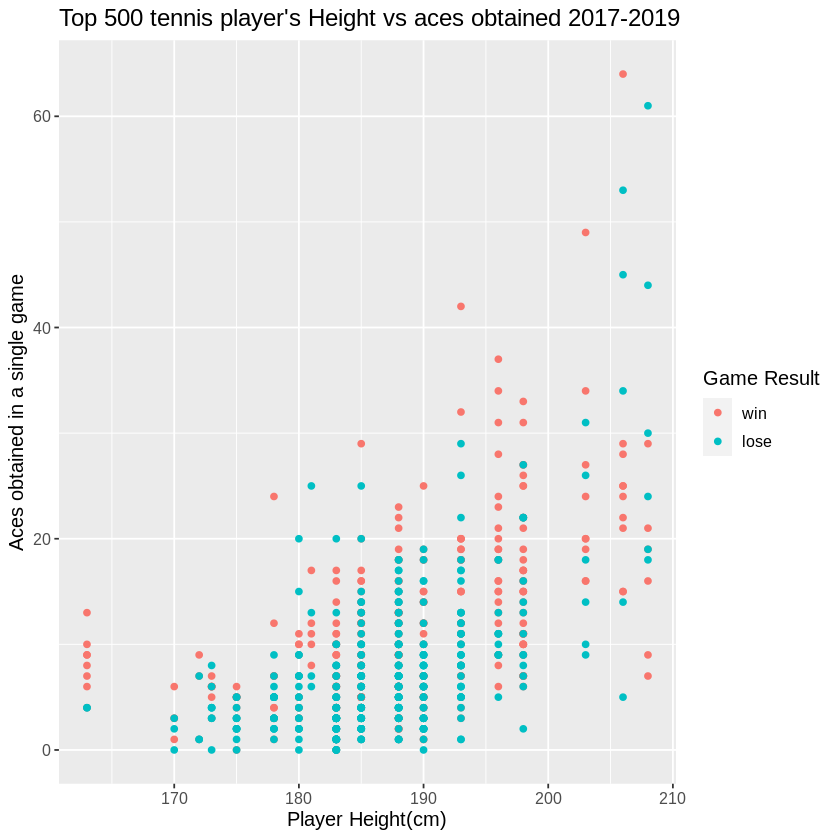

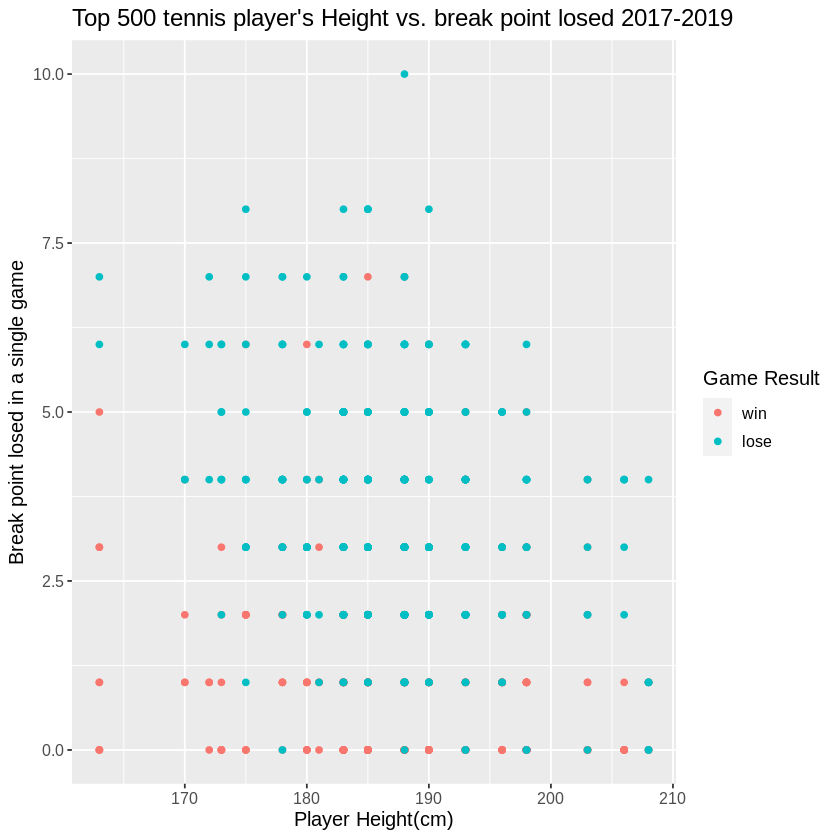

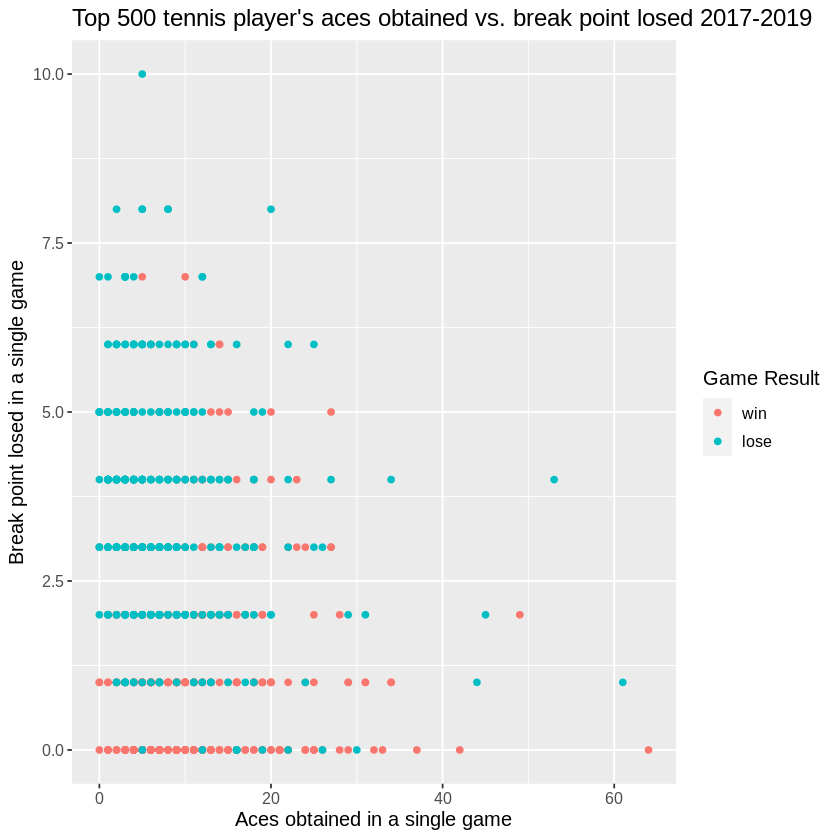

In [7]:
#Visualization of training data set
height_ace_plot<- tennis_train%>%
    ggplot(aes(x=height, y=ace, colour=result))+
    geom_point()+
    labs(x="Player Height(cm)", y="Aces obtained in a single game", colour="Game Result")+
    theme(text=element_text(size=12))+
    ggtitle("Top 500 tennis player's Height vs aces obtained 2017-2019")

height_ace_plot


height_bpLosed_plot<-tennis_train%>%
    ggplot(aes(x=height, y=bpLosed, colour=result))+
    geom_point()+
    labs(x="Player Height(cm)", y="Break point losed in a single game", colour="Game Result")+
    theme(text=element_text(size=12))+
    ggtitle("Top 500 tennis player's Height vs. break point losed 2017-2019")

height_bpLosed_plot


aces_bpLosed_plot<-tennis_train%>%
    ggplot(aes(x=ace, y=bpLosed, colour=result))+
    geom_point()+
    labs(x="Aces obtained in a single game", y="Break point losed in a single game", colour="Game Result")+
    theme(text=element_text(size=12))+
    ggtitle("Top 500 tennis player's aces obtained vs. break point losed 2017-2019")

aces_bpLosed_plot

Figure 1.1-1.3 (top to bottom) Height vs.Aces scatter plot/ Height vs. Break Point Losed scatterplot/ Aces vs. Break Point Losed scatterplot

# IV. Further Data Analysis- Methods

In the next section, a KNN-classification model will be built using standardized data and the decision boundary will be presented on our scatterplot for graph visualization. For all three graphs, the process of finding our decision boundary are the same. First, select the optimum k value by dividing training data set into 10 folds. Utilize the tune() function to obtaine Create a accuracy vs. K(neighbors) graph and select the optimum K with the highest accuracy value. Then build fitted KNN-classification model and test the accuracy of the model built using the test data set. Decision boundaries were then built to see if there is a golden standard of height that can acheive the most aces and bplosed.Three models will be built to analyze the relationship between (1)height vs. aces hit, (2)height vs. breakpoint lost and (3)breakpoints lost vs. aces hit.

# V. Further Data Analysis- Results & Discussion

## Aces vs. Player height(cm)

#### 1. K value selection

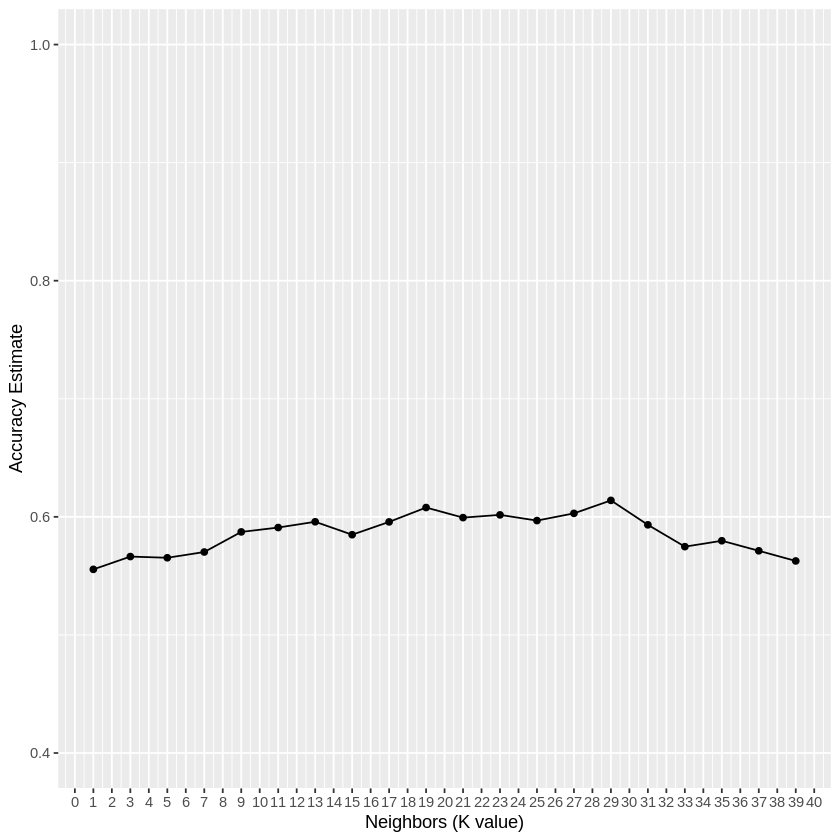

In [31]:
tennis_vfold <- vfold_cv(tennis_train, v = 10, strata = result)

tennis_recipe<- recipe(result~height+ace, data=tennis_train)%>%
    step_scale(all_predictors())%>%
    step_center(all_predictors()) 

knn_tune<-nearest_neighbor(weight_func="rectangular", neighbor=tune())%>%
    set_engine("kknn")%>%
    set_mode("classification")

k_vals <- tibble(neighbors = seq(from = 1, to = 40, by = 2))

knn_results <- workflow() %>%
  add_recipe(tennis_recipe) %>%
  add_model(knn_tune) %>%
  tune_grid(resamples = tennis_vfold, grid = k_vals) %>%
  collect_metrics() 

accuracies<- knn_results %>% 
       filter(.metric=="accuracy")

accuracy_versus_k<- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors (K value)", y = "Accuracy Estimate") +
       scale_x_continuous(breaks = seq(0, 50, by = 1)) +  # adjusting the x-axis
       scale_y_continuous(limits = c(0.4, 1.0)) # adjusting the y-axis
accuracy_versus_k

Figure 2.1 accuracy vs. k plot

<span style="color: blue;">Result: A relatively flat curve is shown, and K=19 is chosen. K=29 has a slightly higher accuracy rate than K=19, with similar accuracy rate, smaller k was chosed since variation it caused will be smaller and prevents underfitting. (Note: Mean accuracy rate for cross validation of K=29 result in lower accuracy rate comparing to K=19, hence K=19 is chosen)</span>

#### 2. Build Fitted Classification Model

In [108]:
#Building fitted model
set.seed(3456)
tennis_model<-nearest_neighbor(weight_func="rectangular", neighbors=19)%>%
    set_engine("kknn")%>%
    set_mode("classification")
tennis_recipe<- recipe(result~height+ace, data=tennis_train)%>%
    step_scale(all_predictors())%>%
    step_center(all_predictors()) 
tennis_workflow<- workflow()%>%
    add_model(tennis_model)%>%
    add_recipe(tennis_recipe)

tennis_fit<-fit(tennis_workflow, data=tennis_train)


#### 3. Test Data Accuracy

In [109]:
#Pass the test dataset into fitted model
tennis_test_prediction<- predict(tennis_fit , tennis_test) %>%
    bind_cols(tennis_test)

#determine accuracy of predictions
tennis_prediction_accuracy<- tennis_test_prediction %>%
         metrics(truth = result, estimate = .pred_class)%>%
         filter(.metric=="accuracy")
tennis_prediction_accuracy


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.5698529


Table 6.1 Test Data Accuracy Rate (for Aces vs. Player Height Model )

<span style="color: blue;">Result: Test data accuracy rate is 56.9%. Accuracy rate is low since only 56.9% of the time the model we built will generate an accurate classification result. </span>

In [110]:
tennis_mat<- tennis_test_prediction %>% 
       conf_mat(truth = result, estimate = .pred_class)

tennis_mat

          Truth
Prediction win lose
      win  103   73
      lose  44   52

Table 6.2 Test Data Result Prediction (for Aces vs. Player Height Model )

In [111]:
#Perform Cross Validation
tennis_vfold <- vfold_cv(tennis_train, v = 10, strata = result)
tennis_resample_fit <- workflow() %>%
       add_recipe(tennis_recipe) %>%
       add_model(tennis_model) %>%
       fit_resamples(resamples = tennis_vfold)
tennis_metrics<-collect_metrics(tennis_resample_fit)%>%
    filter(.metric=="accuracy")
    
tennis_metrics
##high accuracy and low standard error

.metric,.estimator,mean,n,std_err
<chr>,<chr>,<dbl>,<int>,<dbl>
accuracy,binary,0.5993034,10,0.01414614


Table 6.3 Cross Validation Accuracy Rate and Standard Error (for Aces vs. Player Height Model )

<span style="color: blue;">Result: Cross validation's accuracy rate mean is around 60% and Standard error of mean is 1.4%. The accuracy rate is low because only 60% of the time our model will generate an accurate result. The standard error of mean gives us the standard deviation of the sample mean, and thus gives a measure of their spread. Standard error of mean is 1.4% is pretty low indicating the 60% accuracy rate mean has low spread and high accuracy. </span>

#### 4. Create Decision Boundaries

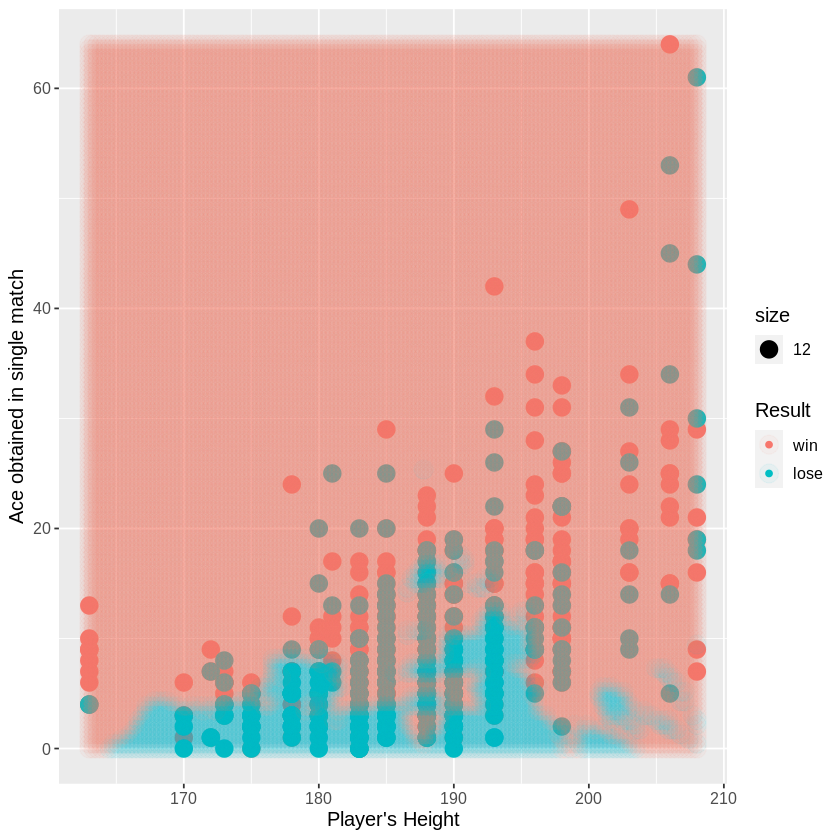

In [115]:
# create the grid of area/smoothness vals, and arrange in a data frame
are_grid <- seq(min(tennis_train$height), 
                max(tennis_train$height), 
                length.out = 150)
smo_grid <- seq(min(tennis_train$ace), 
                max(tennis_train$ace), 
                length.out = 150)
asgrid <- as_tibble(expand.grid(height = are_grid, 
                                ace = smo_grid))

# # use the fit workflow to make predictions at the grid points
knnPredGrid <- predict(tennis_fit, asgrid)

# # bind the predictions as a new column with the grid points
prediction_table <- bind_cols(knnPredGrid, asgrid) %>%
  rename(Class = .pred_class)

# # plot:
# # 1. the colored scatter of the original data
# # 2. the faded colored scatter for the grid points
wkflw_plot <-ggplot() +
  geom_point(data = tennis_train, 
             mapping = aes(x = height, 
                           y = ace, 
                           color = result, 
                           size = 12), 
             alpha = 1) +
  geom_point(data = prediction_table, 
             mapping = aes(x = height, 
                           y = ace, 
                           color = Class), 
             alpha = 0.05, 
             size = 5) +
  labs(color = "Result", 
       x = "Player's Height", 
       y = "Ace obtained in single match") +
  theme(text = element_text(size = 12))
wkflw_plot


Figure 2.2 Decision Boundary (for Aces vs. Player Height Model )

<span style="color: blue;">Discussion1: </span>

- <span style="color: blue;">Improvement of model: The KNN classification model built have a cross validation mean accuracy rate of 0.6 which is a lot lower than expected. The k vs. accuracy graph does not show an usual graph with increase accuracy when K neighbors increase. accuracy maintains the same even when K neighbors increase,this might because the KNN algorithm is not suitable for this data set, another algorithm should be found in order to create a better classification model with higher accuracy. Another improvement is the mechanism of decision boundary model were built to fill the whole plot with color. Look closely to the data points under the colored grid, the upper left of our plot have no data point. The decision boundary plot were not able to provide a clear boundary on where there is no data points, hence another method need to used to find the optimum boundaries.</span>

- <span style="color: blue;">Summarization of Findings vs. Expectation: Take a look at the "data points" in figure 2.2 (not the color grid), as the height of the players increases, more aces was able to be obtained in a single match. This meet our initial assumption of increase in player height result in more aces obtained. However, more aces obtained does not always lead to winning. </span>

- <span style="color: blue;">Further question for our project is to find the optimal height of tennis player. Color grid in Figure 2.2 shows player height 187.5-195 cm have to obtain more aces in order to win the match. This result can be interpret as player with height 187.5-195 cm are more competitive. Hadlich's finding backed up this assumption and narrow down the optimal height to 185 – 190 cm(2021). The reason behind this is becuase player in this height range usually have the advantage of tall and short players. They tend to have the ability to hit the ball at optimal angle(advantage of taller player) and moving fast on the court(advantage of shorter player) which result them to be more competitive(Hadlich, 2021). </span>

## Height vs. BreakPoint Losed

#### 1. K value selection

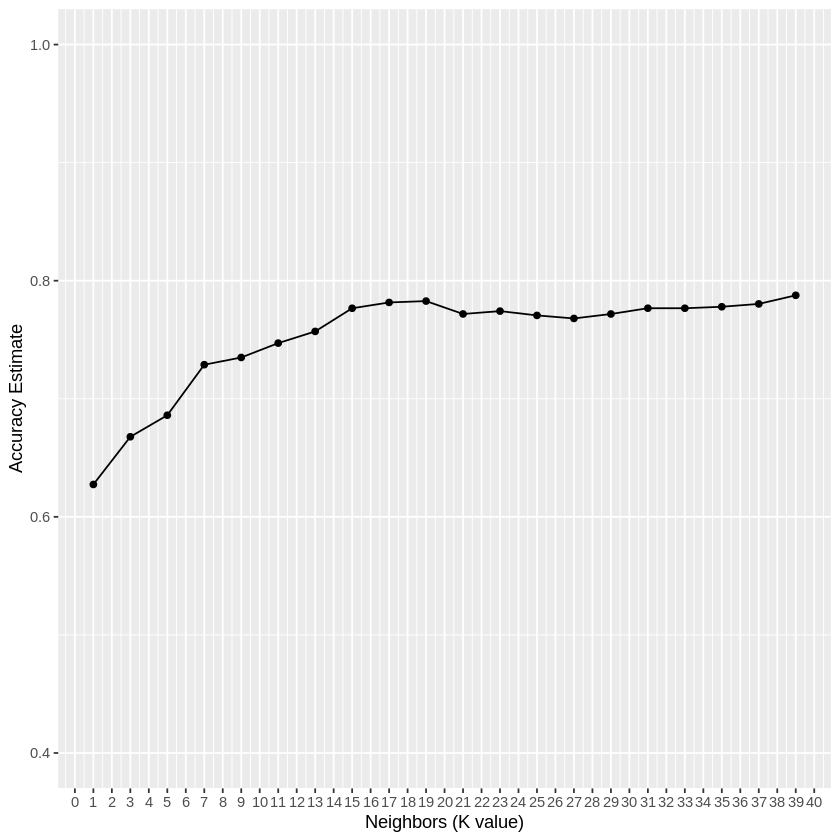

In [13]:
tennis_recipe1<- recipe(result~height+bpLosed, data=tennis_train)%>%
    step_scale(all_predictors())%>%
    step_center(all_predictors()) 

knn_tune<-nearest_neighbor(weight_func="rectangular", neighbor=tune())%>%
    set_engine("kknn")%>%
    set_mode("classification")

k_vals <- tibble(neighbors = seq(from = 1, to = 40, by = 2))

knn_results <- workflow() %>%
  add_recipe(tennis_recipe1) %>%
  add_model(knn_tune) %>%
  tune_grid(resamples = tennis_vfold, grid = k_vals) %>%
  collect_metrics() 

accuracies<- knn_results %>% 
       filter(.metric=="accuracy")

accuracy_versus_k<- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors (K value)", y = "Accuracy Estimate") +
       scale_x_continuous(breaks = seq(0, 50, by = 1)) +  # adjusting the x-axis
       scale_y_continuous(limits = c(0.4, 1.0)) # adjusting the y-axis
accuracy_versus_k
#accuracy is similar, chose smaller k since variation is smaller (improves the accuracy)

Figure 3.1 accuracy vs. k plot

<span style="color: blue;">Result: Accuracy rate increase as number of neighbors increase then reaches a plateau, K=19 is chosen as it has the highest accuracy rate.</span>

#### 2. Build Fitted Classification Model

In [14]:
#Building fitted model
set.seed(3456)
tennis_model<-nearest_neighbor(weight_func="rectangular", neighbors=19)%>%
    set_engine("kknn")%>%
    set_mode("classification")
tennis_workflow1<- workflow()%>%
    add_model(tennis_model)%>%
    add_recipe(tennis_recipe1)

tennis_fit1<-fit(tennis_workflow1, data=tennis_train)

#### 3. Test Accuracy

In [37]:
#Pass the test dataset into fitted model
tennis_test_prediction1<- predict(tennis_fit1 , tennis_test) %>%
    bind_cols(tennis_test)

#determine accuracy of predictions
tennis_prediction_accuracy<- tennis_test_prediction1 %>%
         metrics(truth = result, estimate = .pred_class)%>%
         filter(.metric=="accuracy")
tennis_prediction_accuracy


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7977941


Table 7.1 Test Data Accuracy Rate (for height vs. breakpoint losed model)

<span style="color: blue;">Result: Test data accuracy rate is 79.7%. Accuracy rate is moderate as almost 80% of the time the model we built will generate an accurate classification result.</span>

In [38]:
tennis_mat<- tennis_test_prediction1 %>% 
       conf_mat(truth = result, estimate = .pred_class)

tennis_mat

          Truth
Prediction win lose
      win  125   33
      lose  22   92

Table 7.2 Test Data Result Prediction (for height vs. breakpoint losed model)

<span style="color: blue;">Result: Follow up with the result of table 7.1, the accuracy rate to predict winning result(85%) is higher than predicting the losing result(74%). </span>

In [39]:
#Perform Cross Validation
tennis_vfold <- vfold_cv(tennis_train, v = 10, strata = result)
tennis_resample_fit1 <- workflow() %>%
       add_recipe(tennis_recipe1) %>%
       add_model(tennis_model) %>%
       fit_resamples(resamples = tennis_vfold)
tennis_metrics<-collect_metrics(tennis_resample_fit1)%>%
    filter(.metric=="accuracy")
tennis_metrics
##high accuracy and low standard error

.metric,.estimator,mean,n,std_err
<chr>,<chr>,<dbl>,<int>,<dbl>
accuracy,binary,0.7827394,10,0.0128988


Table 7.3 Cross Validation Accuracy Rate and Standard Error (for height vs. breakpoint losed model)

<span style="color: blue;">Result: Cross validation's accuracy rate mean is around 78.3% and Standard error of mean is 1.2%. Standard error of mean is 1.2% is pretty low indicating the 78.3% accuracy rate mean has high accuracy and low spread.</span>

#### 4. Create Decision Boundaries

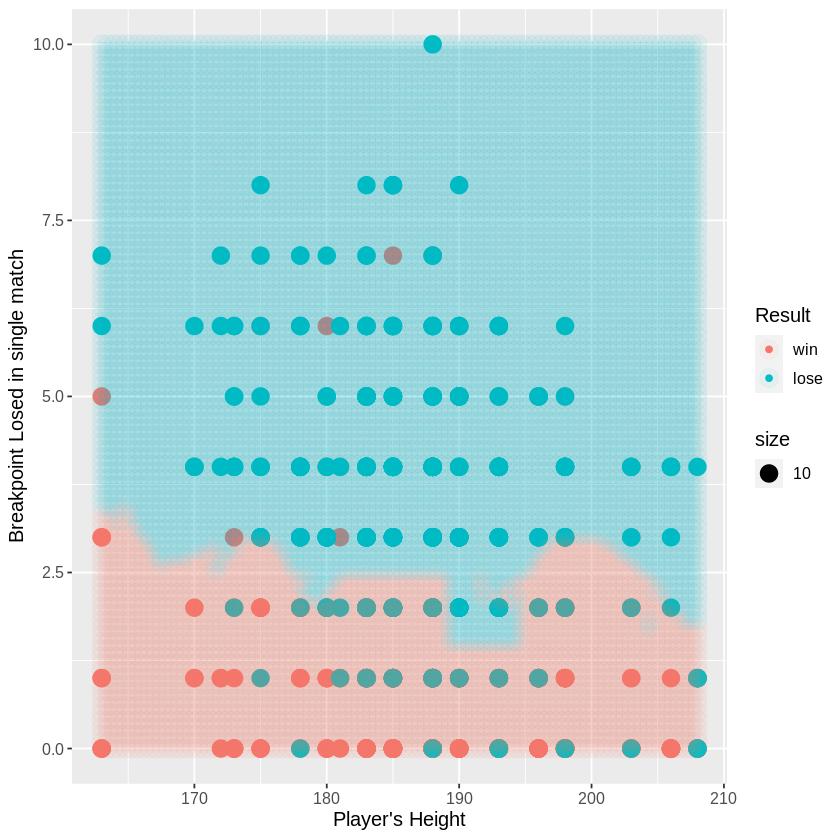

In [98]:
set.seed(3456)
# create the grid of area/smoothness vals, and arrange in a data frame
are_grid <- seq(min(tennis_train$height), 
                max(tennis_train$height), 
                length.out = 100)
smo_grid <- seq(min(tennis_train$bpLosed), 
                max(tennis_train$bpLosed), 
                length.out = 100)
asgrid <- as_tibble(expand.grid(height = are_grid, 
                               bpLosed = smo_grid))

# # use the fit workflow to make predictions at the grid points
knnPredGrid <- predict(tennis_fit1, asgrid)

# # bind the predictions as a new column with the grid points
prediction_table <- bind_cols(knnPredGrid, asgrid) %>%
  rename(Class = .pred_class)

# # plot:
# # 1. the colored scatter of the original data
# # 2. the faded colored scatter for the grid points
wkflw_plot <-
  ggplot() +
  geom_point(data = tennis_train, 
             mapping = aes(x = height, 
                           y = bpLosed, 
                           color = result, 
                           size = 10), 
             alpha = 1) +
  geom_point(data = prediction_table, 
             mapping = aes(x = height, 
                           y = bpLosed, 
                           color = Class), 
             alpha = 0.05, 
             size = 5) +
  labs(color = "Result", 
       x = "Player's Height", 
       y = "Breakpoint Losed in single match") +
  theme(text = element_text(size = 12))

wkflw_plot

Figure 3.2 Decision Boundary (for height vs. breakpoint losed model)


<span style="color: blue;">Discussion2: </span>

- <span style="color: blue;">Improvement of the model: The KNN-classification model built have a high accuracy on predicting winning result with a accuracy rate of 85% and moderate accuracy rate on predicting losing result(74%) which is better than the first model. The k vs. accuracy graph(figure 3.1) does not show an usual graph with increase accuracy when K neighbors increase which is unexpected. Our decision boundary looks underfitted despite using the optimal K value using the k with highest accuracy rate in figure 3.1. The unusual k vs. accuracy grap might be a cause of the underfitted decision boundary. Another possible reason could be KNN algorithm is not suitable for this data set, another algorithm should be found in order to create a better classification model with higher accuracy. </span>

- <span style="color: blue;">Summarization of Findings vs. Expectation: Since the decision boundary is underfitted, take a look at the "data points" in figure 3.2 (not the color grid). Our assumption is that taller player tend to lose less breakpoints. This seems to be true for only players above 187.5 cm. Player's height below 187.5 cm, even if height decreases, the breakpoints  they losed seems to be in the same range. Another finding is losing less breakpoints (at most lose 1 point) have higher winning rate this meets our assumption. </span>

- <span style="color: blue;">Further question for our project is to find the optimal height of tennis player. From the previous discussion for figure 2.2, optimal height for tennis player is considered between 187.5- 195cm as they have the ability to obtain the more aces than other height group. Figure 3.2 shows over 190cm have significant decrease in the "maximum breakpoint losed" in a single match. This narrow down our range of optimal height for tennis player to 190-195cm.  </span>

# Ace vs. Breakpoint Losed

#### 1. K value selection

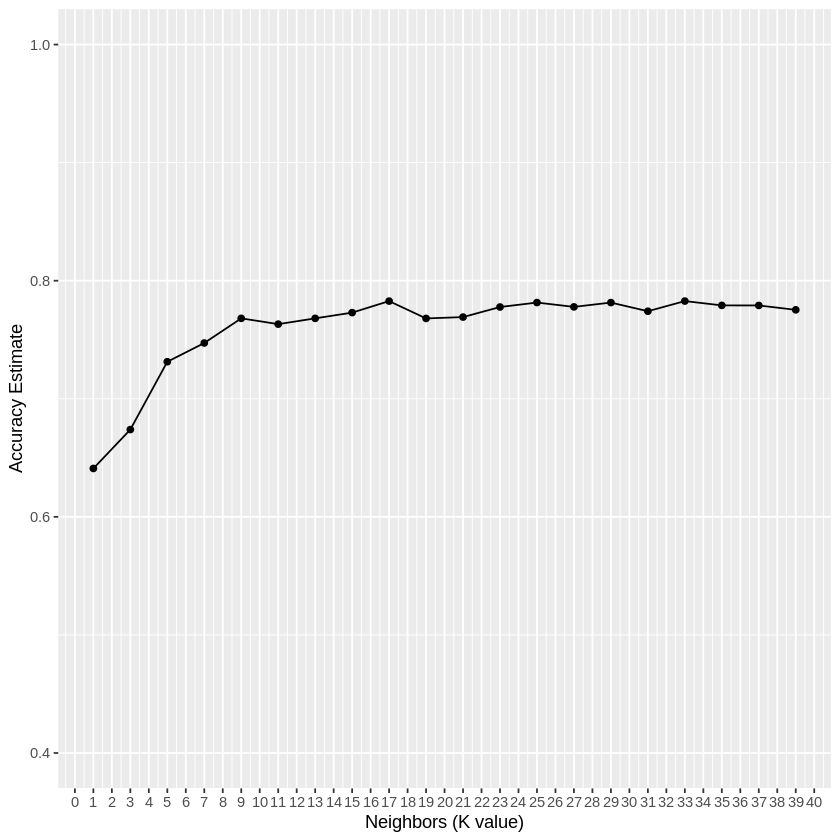

In [116]:
tennis_recipe2<- recipe(result~ace+bpLosed, data=tennis_train)%>%
    step_scale(all_predictors())%>%
    step_center(all_predictors()) 

knn_tune<-nearest_neighbor(weight_func="rectangular", neighbor=tune())%>%
    set_engine("kknn")%>%
    set_mode("classification")

k_vals <- tibble(neighbors = seq(from = 1, to = 40, by = 2))

knn_results <- workflow() %>%
  add_recipe(tennis_recipe2) %>%
  add_model(knn_tune) %>%
  tune_grid(resamples = tennis_vfold, grid = k_vals) %>%
  collect_metrics() 

accuracies<- knn_results %>% 
       filter(.metric=="accuracy")

accuracy_versus_k<- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors (K value)", y = "Accuracy Estimate") +
       scale_x_continuous(breaks = seq(0, 50, by = 1)) +  # adjusting the x-axis
       scale_y_continuous(limits = c(0.4, 1.0)) # adjusting the y-axis
accuracy_versus_k
#accuracy is similar, chose smaller k since variation is smaller (improves the accuracy)

Figure 4.1 accuracy vs. k plot

<span style="color: blue;">Result: Accuracy rate increase as number of neighbors increase then reaches a plateau, K=17 is chosen as it has the highest accuracy rate.</span>

#### 2. Build Fitted Classification Model

In [117]:
#Building fitted model
set.seed(3456)
tennis_model<-nearest_neighbor(weight_func="rectangular", neighbors=17)%>%
    set_engine("kknn")%>%
    set_mode("classification")
tennis_workflow2<- workflow()%>%
    add_model(tennis_model)%>%
    add_recipe(tennis_recipe2)

tennis_fit2<-fit(tennis_workflow2, data=tennis_train)

#### 3. Test Accuracy

In [118]:
#Pass the test dataset into fitted model
tennis_test_prediction2<- predict(tennis_fit2 , tennis_test) %>%
    bind_cols(tennis_test)
#determine accuracy of predictions
tennis_prediction_accuracy<- tennis_test_prediction2 %>%
         metrics(truth = result, estimate = .pred_class)%>%
    filter(.metric=="accuracy")
tennis_prediction_accuracy


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.75


Table 8.1 Test Data Accuracy Rate (for Aces vs. Breakpoint Losed Model)


<span style="color: blue;">Result: Test data accuracy rate is 75%. Accuracy rate is moderate as 75% of the time the model we built will generate an accurate classification result.</span>

In [119]:
tennis_mat<- tennis_test_prediction2 %>% 
       conf_mat(truth = result, estimate = .pred_class)

tennis_mat

          Truth
Prediction win lose
      win  117   38
      lose  30   87

Table 8.2 Test Data Result Prediction (for Aces vs. Breakpoint Losed Model)


In [120]:
#Perform Cross Validation
tennis_vfold <- vfold_cv(tennis_train, v = 10, strata = result)
tennis_resample_fit2 <- workflow() %>%
       add_recipe(tennis_recipe2) %>%
       add_model(tennis_model) %>%
       fit_resamples(resamples = tennis_vfold)
tennis_metrics<-collect_metrics(tennis_resample_fit2)%>%
    filter(.metric=="accuracy")
tennis_metrics
##high accuracy and low standard error

.metric,.estimator,mean,n,std_err
<chr>,<chr>,<dbl>,<int>,<dbl>
accuracy,binary,0.7645353,10,0.01135956


Table 8.3 Cross Validation Accuracy Rate and Standard Error (for Aces vs. Breakpoint Losed Model)

<span style="color: blue;"> Result: Cross validation's accuracy mean rate is around 76.4% and standard error of mean is 1.4%. Standard error of mean is pretty low indicating the 76.4% accuracy rate mean has high accuracy.</span>


#### 4. Create Decision Boundaries

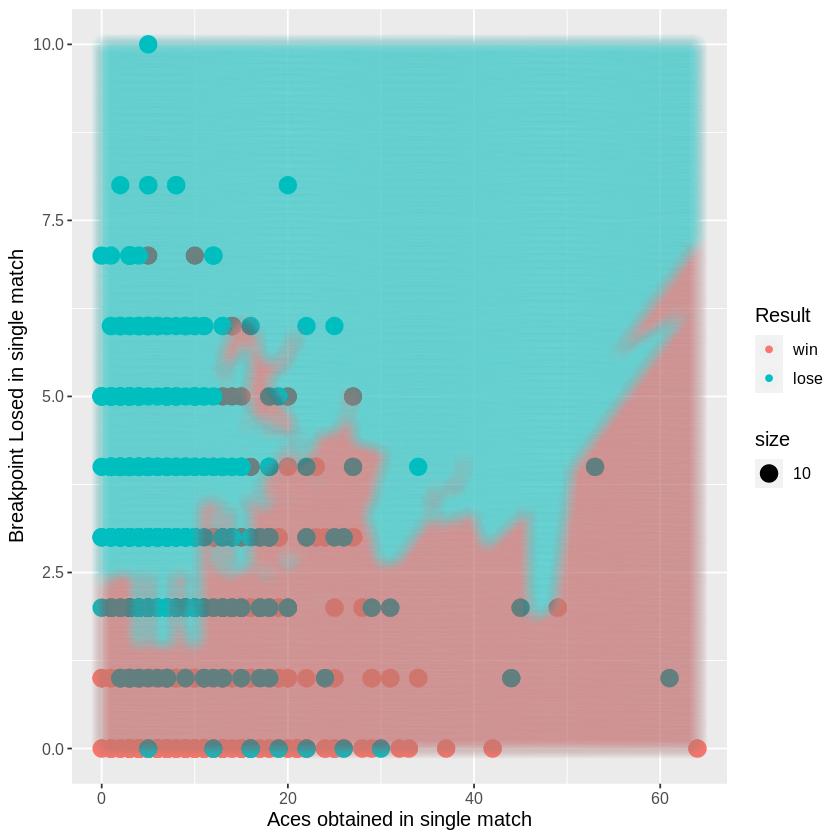

In [123]:
set.seed(3456)
tennis_recipe2<- recipe(result~ace+bpLosed, data=tennis_train)%>%
    step_scale(all_predictors())%>%
    step_center(all_predictors())
tennis_model<-nearest_neighbor(weight_func="rectangular", neighbors=11)%>%
    set_engine("kknn")%>%
    set_mode("classification")
tennis_workflow2<- workflow()%>%
    add_model(tennis_model)%>%
    add_recipe(tennis_recipe2)

tennis_fit<-fit(tennis_workflow2, data=tennis_train)


# create the grid of area/smoothness vals, and arrange in a data frame
are_grid <- seq(min(tennis_train$ace), 
                max(tennis_train$ace), 
                length.out = 300)
smo_grid <- seq(min(tennis_train$bpLosed), 
                max(tennis_train$bpLosed), 
                length.out = 300)
asgrid <- as_tibble(expand.grid(ace = are_grid, 
                               bpLosed = smo_grid))

# # use the fit workflow to make predictions at the grid points
knnPredGrid <- predict(tennis_fit, asgrid)

# # bind the predictions as a new column with the grid points
prediction_table <- bind_cols(knnPredGrid, asgrid) %>%
  rename(Class = .pred_class)

# # plot:
# # 1. the colored scatter of the original data
# # 2. the faded colored scatter for the grid points
wkflw_plot <-
  ggplot() +
  geom_point(data = tennis_train, 
             mapping = aes(x = ace, 
                           y = bpLosed, 
                           color = result, 
                           size = 10), 
             alpha = 1) +
  geom_point(data = prediction_table, 
             mapping = aes(x = ace, 
                           y = bpLosed, 
                           color = Class), 
             alpha = 0.01, 
             size = 5) +
  labs(color = "Result", 
       x = "Aces obtained in single match", 
       y = "Breakpoint Losed in single match") +
  theme(text = element_text(size = 12))

wkflw_plot

Figure 4.2 Decision Boundary(for Aces vs. Breakpoint Losed Model)

<span style="color: blue;">Discussion3:</span>
- <span style="color: blue;">Improvement of the model: Similar improvement needs to be done as mentioned in the previous discussion sections . The k vs. accuracy graph(figure 4.1) in this section reaches a plateau which is not a usual trend. Upper right of the plot doesn't contain data points, however, decision boundary have a characteristic of filling the whole plot with color grids which is a limitation of our graph. </span>

- <span style="color: blue;">Summarization of Findings vs. Expectation: Focus on the data points in figure 4.2, overall trend shows as the number of aces obtained increases, the number of breakpoints lost in a single match will decrease. This matches our assumption of better server have better ability to break a serve, hence losing less breakpoints (Sackmann, 2018). Another finding is no matter how many aces you obtained, if the player is able to not lose any breakpoints, winning rate is high. This correspond with the definition of breakpoint which is a break point occurs when two conditions are met: 1) one player is one point away from a win the game, and 2) their opponent is serving. Since in tennis, four points win a game, six games win a set, and two or three sets win a match, saving a breakpoint (1 point) in a game indicates you're blocking your opponent from winning the match. </span>


# Conclusion #

Impact of overall findings (from the discussion of 3 graphs) & Further studies can be done moving forward: 


- From Discussion1 and 2, result shown height indeed matters in the game of tennis. Our finding suggested that tennis player within the height group of 190-195cm won the most aces and overall losed the less break points in a single match. We found the sweet spot in height for tennis player. Future studies should take more variables into account to increase the validity of the optimal height we found for tennis player. As most tennis player starts trainning at a young age, improve young tennis player’s nutritional health and include more nutritents that promote growth and bone health to achieve this height is important and could make an impact on the player's career. 

- Findings from Discussion3 suggested the ability to save breakpoints are more important than obtaining high number of aces in a match. Training menu should focus on enhancing players mental strength on how to play well under pressure when facing a breakpoint. 

- After finding a better algorithm to build our classification model, our project will have a big impact on helping people who indluge in sports betting to win. Optimizing our decision boundary, can help coaches set training goals for their players with different heights. As height indeed shows an impact on game results. The ability to quantify the min aces need to obtained and max breakpoint they can lose in a single match, increase confidence in tennis players.
 

# References

1)Hadlich, G. (2021, January 30). What is the average height of tennis players? My Tennis HQ. Retrieved April 9, 2022, from https://mytennishq.com/what-is-the-average-height-of-tennis-players/

2)Sackmann, J. (2018, September 1). How much does height matter in men's tennis? Heavy Topspin. Retrieved April 9, 2022, from 
http://www.tennisabstract.com/blog/2017/09/04/how-much-does-height-matter-in-mens-tennis/


3)Sackmann, J. (2022, Feb 13).Retrieved April 9, 2022, from 
https://github.com/JeffSackmann/tennis_atp/blob/master/atp_matches_2015.csv